#  «Анализ данных об оптовых продажах аудиотехники»

В рамках анализа данных об оптовых продажах аудиотехники будут проведены:
1) Сбор, очистка и объединение данных для их анализа
2) Определение ключевых тенденций в продажах в течение месяца
3) Определение и расчет ключевых метрик
4) Сегментация, план оптимизации товарной линейки
5) Визуализация динамики основных метрик во времени
6) Анализ эффективности работы менеджеров по продажам
7) Отчет о проведенной работе (кратко описаны все части выполненой работы)

In [846]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Соберем датасет с заказами по папкам

Сначала соберу данные из всех папок в несколько датафреймов: 
1. `df_orders` — на основе датасетов `orders.csv` + колонка `manager` с именами менеджеров и колонка `date` с датами. 
2. `df_order_status` — на основе датасетов `order_status.csv`.  
3. `df_products` — на основе датасетов `products.csv` + колонка `category` с категориями товаров. 

Далее все датафреймы сохраню в виде csv файлов, чтобы возможно было использовать эти данные при других анализах в будущем.

Чтение и конкатинация данных в 3 датафрейма:

In [847]:
p = r'D:\GitHubProjects\da_project_audio_sales\data'
df_orders = pd.DataFrame()
df_order_status = pd.DataFrame()
df_products = pd.DataFrame()
for path, dirs, files in os.walk(p):
    for i in files:
        if i.endswith('orders.csv'):
            link = os.path.join(path,i)
            d = pd.read_csv(link)
            d['manager'] = link.split('\\')[-2]
            d["date"] = link.split('\\')[-3]
            df_orders = pd.concat([df_orders, d])
        elif i.endswith('order_status.csv'):
            link = os.path.join(path,i)
            d = pd.read_csv(link)
            df_order_status = pd.concat([df_order_status, d])
        elif i.endswith('products.csv'):
            link = os.path.join(path,i)
            d = pd.read_csv(link)
            d['category'] = link.split('\\')[-2]
            df_products = pd.concat([df_products, d])


In [848]:
df_order_status.reset_index(inplace = True, drop = True)
df_orders.reset_index(inplace = True, drop = True)
df_products.reset_index(inplace = True, drop = True)

In [849]:
df_order_status

,order_id,client_id,status
0,DUEU-27693834,14,confirmed
1,VHJV-14331014,43,confirmed
2,MSXQ-45152143,61,confirmed
3,LOSS-76956574,94,confirmed
4,OPAU-19106120,33,confirmed
...,...,...,...
341,UBQN-94821029,35,confirmed
342,JHUM-48790671,70,confirmed
343,XRPC-48091227,52,confirmed
344,RJPI-21712323,22,confirmed


Далее изменим тип некоторых данных и сохраним датафреймы в качестве csv файлов:

In [850]:
df_orders.date = pd.to_datetime(df_orders.date)

In [851]:
df_order_status.to_csv("df_order_status.csv", index = False)
df_orders.to_csv("df_orders.csv", index = False)
df_products.to_csv("df_products.csv", index = False)

# Посмотрим на общую динамику заказов и определим дни, которые выбиваются из общей картины

## 1 

Для начала найду сколько заказов в день совершается и выведу дни с наибольшим количеством заказов:

In [852]:
total_orders_by_day = df_orders\
.groupby("date", as_index = False)\
.agg({"order_id":"count"})\
.rename(columns = {"order_id": "total_orders"})\
.sort_values(by = "total_orders", ascending = False)\
.reset_index(drop = True)

In [853]:
total_orders_by_day.head()

,date,total_orders
0,2024-03-14,437
1,2024-03-13,339
2,2024-03-01,302
3,2024-03-29,241
4,2024-03-26,231


## 2

Далее построю график зависимости количества заказов от дня недели, когда заказы были совершены:

In [854]:
df_orders['weekday'] = df_orders.date.dt.day_name()

In [855]:
total_orders_by_weekday = df_orders\
.groupby("weekday", as_index = False)\
.agg({"order_id":"count"})\
.rename(columns = {"order_id": "total_orders"})\
.sort_values(by = "total_orders", ascending = False)\
.reset_index(drop = True)

In [856]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [857]:
total_orders_by_weekday.weekday = total_orders_by_weekday.weekday.astype("category")
total_orders_by_weekday.weekday = total_orders_by_weekday.weekday.cat.set_categories(order)

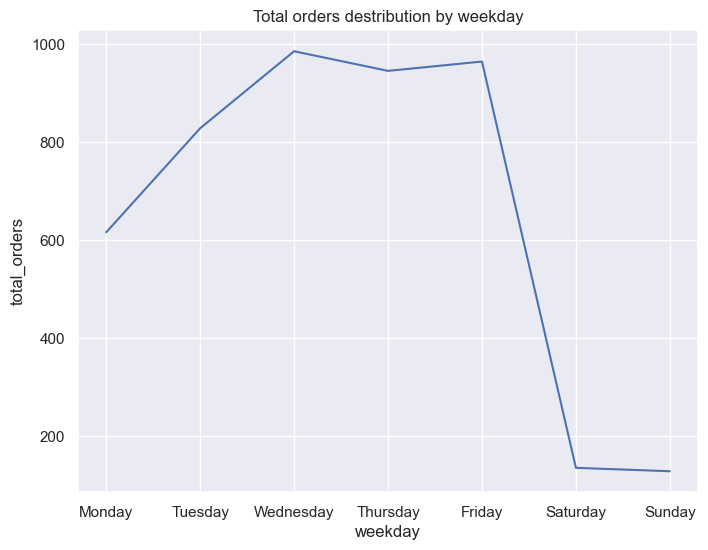

In [858]:
plt.figure(figsize = (8,6))
sns.set_theme()
sns.lineplot(data = total_orders_by_weekday,\
             x = 'weekday', y = 'total_orders')
plt.title("Total orders destribution by weekday")
plt.show()

В итоге получаем, что наибольшее количество заказов оформляется во второй половине недели в будние дни. В выходные заказов почти нет.

## 3

Расчитаю среднее количество заказов, сделанные в определенные дни недели.

In [859]:
avg_orders_by_weekday = df_orders\
.groupby(["date", 'weekday'], as_index = False)\
.agg({"order_id":"count"})\
.groupby('weekday', as_index = False)\
.agg({"order_id":'mean'})\
.rename(columns = {"order_id": "avg_orders"})\
.sort_values(by = "avg_orders", ascending = False)\
.reset_index(drop = True)

In [860]:
avg_orders_by_weekday.weekday = avg_orders_by_weekday.weekday.astype("category")
avg_orders_by_weekday.weekday = avg_orders_by_weekday.weekday.cat.set_categories(order)

In [861]:
avg_orders_by_weekday

,weekday,avg_orders
0,Wednesday,246.250
1,Thursday,236.250
2,Tuesday,207.000
3,Friday,192.800
4,Monday,154.000
5,Saturday,27.200
6,Sunday,25.800


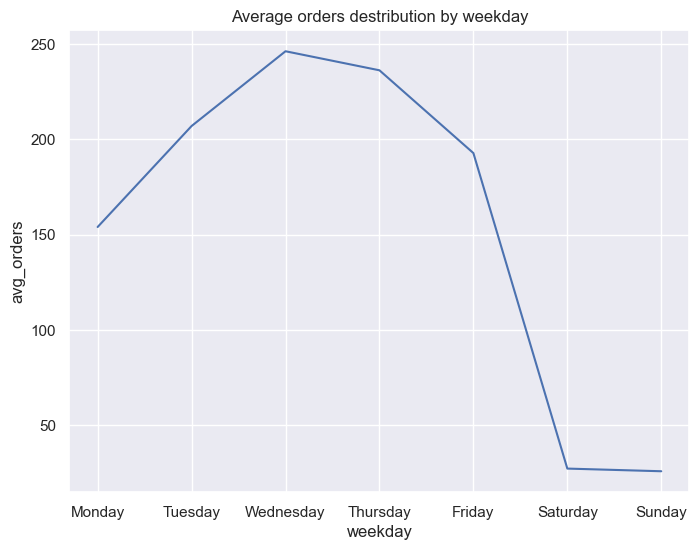

In [862]:
plt.figure(figsize = (8,6))
sns.set_theme()
sns.lineplot(data = avg_orders_by_weekday,\
             x = 'weekday', y = 'avg_orders')
plt.title("Average orders destribution by weekday")
plt.show()

Среднее количество заказов почти совпадает с общим распределением заков по дням недели. Изменения в динамике наблюдаются только в пятницу (средний чек падает по сравнению с четвергом, общее количество заказов увеличивается).

## 4

Далее попробую найти дни, которые выбиваются из описанной выше "сезонности":

In [863]:
date_weekday = df_orders.loc[:,['date','weekday']].drop_duplicates()

In [864]:
total_orders_by_day = total_orders_by_day.merge(date_weekday, on = 'date')

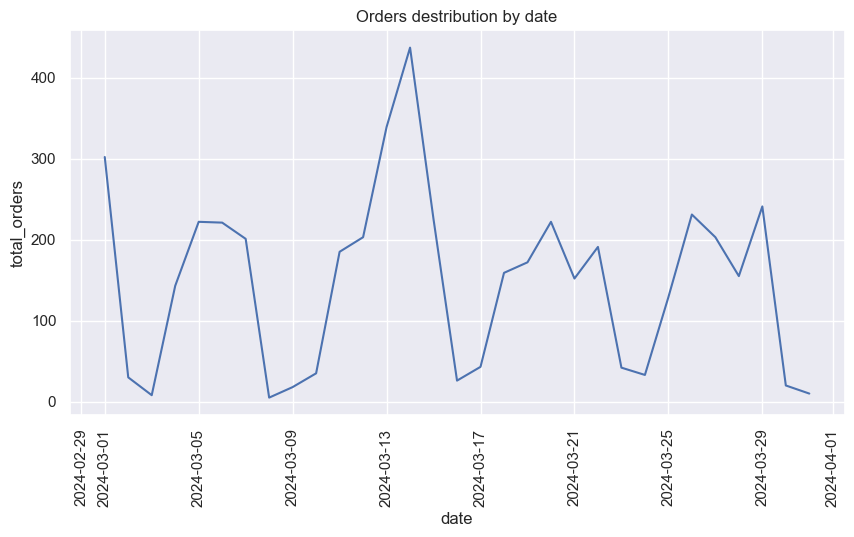

In [865]:
plt.figure(figsize = (10,5))
sns.set_theme()
sns.lineplot(data = total_orders_by_day,\
             x = 'date', y = 'total_orders')
plt.title("Orders destribution by date")
plt.xticks(rotation = 90)
plt.show()

In [866]:
total_orders_by_day

,date,total_orders,weekday
0,2024-03-14,437,Thursday
1,2024-03-13,339,Wednesday
2,2024-03-01,302,Friday
3,2024-03-29,241,Friday
4,2024-03-26,231,Tuesday
5,2024-03-15,225,Friday
6,2024-03-05,222,Tuesday
7,2024-03-20,222,Wednesday
8,2024-03-06,221,Wednesday
9,2024-03-27,203,Wednesday


На основе графика продаж по дням, а также таблицы, можно сделать вывод, что 2024-03-08 - нетипичная пятница. В этот день покупатали почти не совершали заказов, хотя исходя из "сезонности" должны были.

8 марта - праздничный день, вероятно в этот день покупатели в целом были не готовы заниматься шоппингом в любом его виде. Также возможно это связано с особенностями работы системы отчетности.

## 5

Попробуем определить, почему в некоторые дни наблюдался настолько резкий рост продаж (например, 13-14 марта):

Для начала соединю заказы с их статусами. Возможно, большинство из оформленных в тот день заказов были отменены.
Сохряню полученный датафрейм в отдельный csv файл.

In [867]:
orders_status = df_orders.merge(df_order_status, on = 'order_id')

In [868]:
orders_status.loc[:,orders_status.columns != 'weekday'].to_csv('orders_status.csv', index = False)

## 6

Посмотрю на количество и соотношение подтвержденных и отмененных заказов в целом по всему обьему данных.

In [869]:
orders_status.status.value_counts(normalize=True)


status
confirmed   0.887
canceled    0.113
Name: proportion, dtype: float64

Получаем, что 11% всех заказов были отменены.

## 7

Определю количество подтвержденных и отмененных заказов на каждую дату построив сводную таблицу:

In [870]:
status_pivot = orders_status\
.groupby(['date', 'status'], as_index = False)\
.agg({"order_id":"count"})\
.rename(columns = {"order_id":"total_orders"})\
.pivot(index = 'date', columns = 'status', values = 'total_orders')\
.fillna(0)



In [871]:
status_pivot = status_pivot.rename(columns = {"canceled": 'total_canceled', 'confirmed':"total_confirmed"})

In [872]:
status_pivot

status,total_canceled,total_confirmed
date,,
2024-03-01,29.000,273.000
2024-03-02,0.000,30.000
2024-03-03,0.000,8.000
2024-03-04,0.000,143.000
2024-03-05,0.000,222.000
2024-03-06,12.000,209.000
2024-03-07,5.000,196.000
2024-03-08,0.000,5.000
2024-03-09,18.000,0.000


Видим, что 13 марта было очень большое количество отмененных заказов. Возможно именно с этим связан такой рост заказов 14 марта.

## 8

Построю график с заказами по дням с разбивкой по статусам:

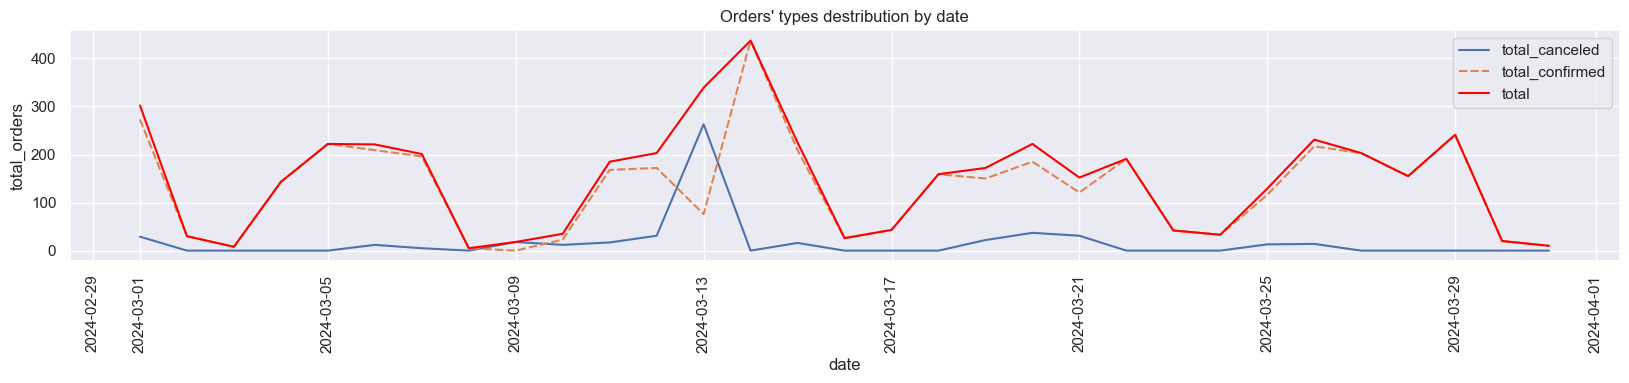

In [873]:
plt.figure(figsize = (20,3))
sns.set_theme()
sns.lineplot(data = status_pivot)
sns.lineplot(data = total_orders_by_day, x = 'date', y = 'total_orders', label = 'total', color = 'red')
plt.title("Orders' types destribution by date")
plt.xticks(rotation = 90)
plt.ylabel("total_orders")
plt.show()

Итого получаем, что в целом неделя с 11 по 17 марта была типичной по количеству заказов. 
В этой неделе интерес представляют только 2 дня - 13 и 14 марта.

## 9

Определю, совпадают ли заказы, которые были совершены 13 марта (все, отменные и неотменненные) с заказами 14 марта. 
Буду считать, что заказ повторяет вчерашний если у него совпадают id клиента, id менеджера, количество и наименование товара.

In [874]:
orders_status.query("(date == '2024-03-14') or (date == '2024-03-13')")\
.groupby(['client_id', 'manager', 'quantity', 'product_id'] ,as_index = False)\
.agg({"order_id":'count'})\
.rename(columns = {"order_id":'total_orders'})\
.sort_values(by = 'total_orders', ascending = False)\
.total_orders.value_counts()

C:\Users\egona\AppData\Local\Temp\ipykernel_20804\941789113.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  orders_status.query("(date == '2024-03-14') or (date == '2024-03-13')")\


total_orders
1    330
2    223
Name: count, dtype: int64

Итого получаю, что 223 заказа (почти половина от всех), которые были совершены 13 марта, повторяются 14 марта. 
Делаю предположение, что сбой в CRM системе 13 марта привел к тому, что большинство заказов были отменены и их в автоматическом режиме пересоздали уже на следующий день - 14 марта.

# Посчитаем ключевые метрики, посмотрим на их динамику

## 10

Товары компания покупает за рубежом за доллары, а продает в России за рубли. Для расчета ключевых метрик мне нужно работать в валюте продаж. Поэтому буду использовать курс доллара за каждый из дней месяца для перевода выручки за каждую продажу к рубли.

In [875]:
usd_rates = pd.read_csv("usd_rate.txt", header = None)\
.iloc[:,0:2]\
.rename(columns = {0:"date", 1:"currency_rate"})



Определю средний курс доллара за месяц.

In [876]:
usd_rates.currency_rate.mean()

np.float64(91.69706451612903)

In [877]:
usd_rates.date = pd.to_datetime(usd_rates.date) 

## 11

Начну с подсчета выручки в рублях с каждого заказа:

In [878]:
orders_status.head()

,order_id,product_id,quantity,manager,date,weekday,client_id,status
0,DUEU-27693834,933,7,Алексей Саксофонов,2024-03-01,Friday,14,confirmed
1,DUEU-27693834,1645,36,Алексей Саксофонов,2024-03-01,Friday,14,confirmed
2,DUEU-27693834,1596,40,Алексей Саксофонов,2024-03-01,Friday,14,confirmed
3,DUEU-27693834,648,10,Алексей Саксофонов,2024-03-01,Friday,14,confirmed
4,DUEU-27693834,1413,6,Алексей Саксофонов,2024-03-01,Friday,14,confirmed


Присоединю к датафрейму заказов товар, который есть в заказе и курс доллара на момент оформаления заказа:

In [879]:
df_full = orders_status\
.merge(df_products, left_on = 'product_id', right_on = 'id')\
.merge(usd_rates, on = 'date')

Создам колонку с выручкой и посчитаю ее перемножением курса доллара на стоимость товара в долларах на количество товаров:

In [880]:
df_full['revenue'] = (df_full['quantity']*df_full['price']*df_full['currency_rate'])
df_full['revenue_in_usd'] = (df_full['quantity']*df_full['price'])

Отберу только подтвержденные заказы:

In [881]:
df_confirmed = df_full.query("status == 'confirmed'")

Посчитаю общую выручку в рублях за месяц:

In [882]:
df_confirmed.revenue.sum()

np.float64(2038231821.564864)

## 12

Далее расчитаю средний чек в этом месяце:

In [883]:
df_confirmed.revenue.sum()/ df_confirmed.order_id.nunique()


np.float64(6596219.487264932)

## 13

Далее расчитаю выручку, средний чек и число заказов на каждый день:

In [884]:
metrics_by_date = df_full\
.groupby(["date",'order_id'], as_index = False)\
.agg({'revenue':"sum"})\
.reset_index(drop = True)\
.groupby('date', as_index = False)\
.agg({'revenue':["sum", 'mean'], 'order_id':pd.Series.nunique})

In [885]:
metrics_by_date.head()

date       revenue             order_id
                       sum        mean  nunique
0 2024-03-01 167781069.707 7626412.259       22
1 2024-03-02  11971668.527 5985834.264        2
2 2024-03-03   2548418.421 2548418.421        1
3 2024-03-04  64049925.587 6404992.559       10
4 2024-03-05  89527238.226 4973735.457       18

Оптимизирую таблицу, сделаю ее более читаемой:

In [886]:
metrics_by_date = metrics_by_date.droplevel(0, axis=1).rename_axis(None, axis=1)


In [887]:
metrics_by_date = metrics_by_date.rename(columns={metrics_by_date.columns[0]: 'date'})

In [888]:
metrics_by_date[["sum", "mean"]] = metrics_by_date[["sum", "mean"]].apply(lambda x: round(x,1))

In [889]:
metrics_by_date.head()

,date,sum,mean,nunique
0,2024-03-01,167781069.700,7626412.300,22
1,2024-03-02,11971668.500,5985834.300,2
2,2024-03-03,2548418.400,2548418.400,1
3,2024-03-04,64049925.600,6404992.600,10
4,2024-03-05,89527238.200,4973735.500,18


Построю 3 графика с общей осью OX, для количества заказов, суммы заказов и среднего чека в день за месяц:

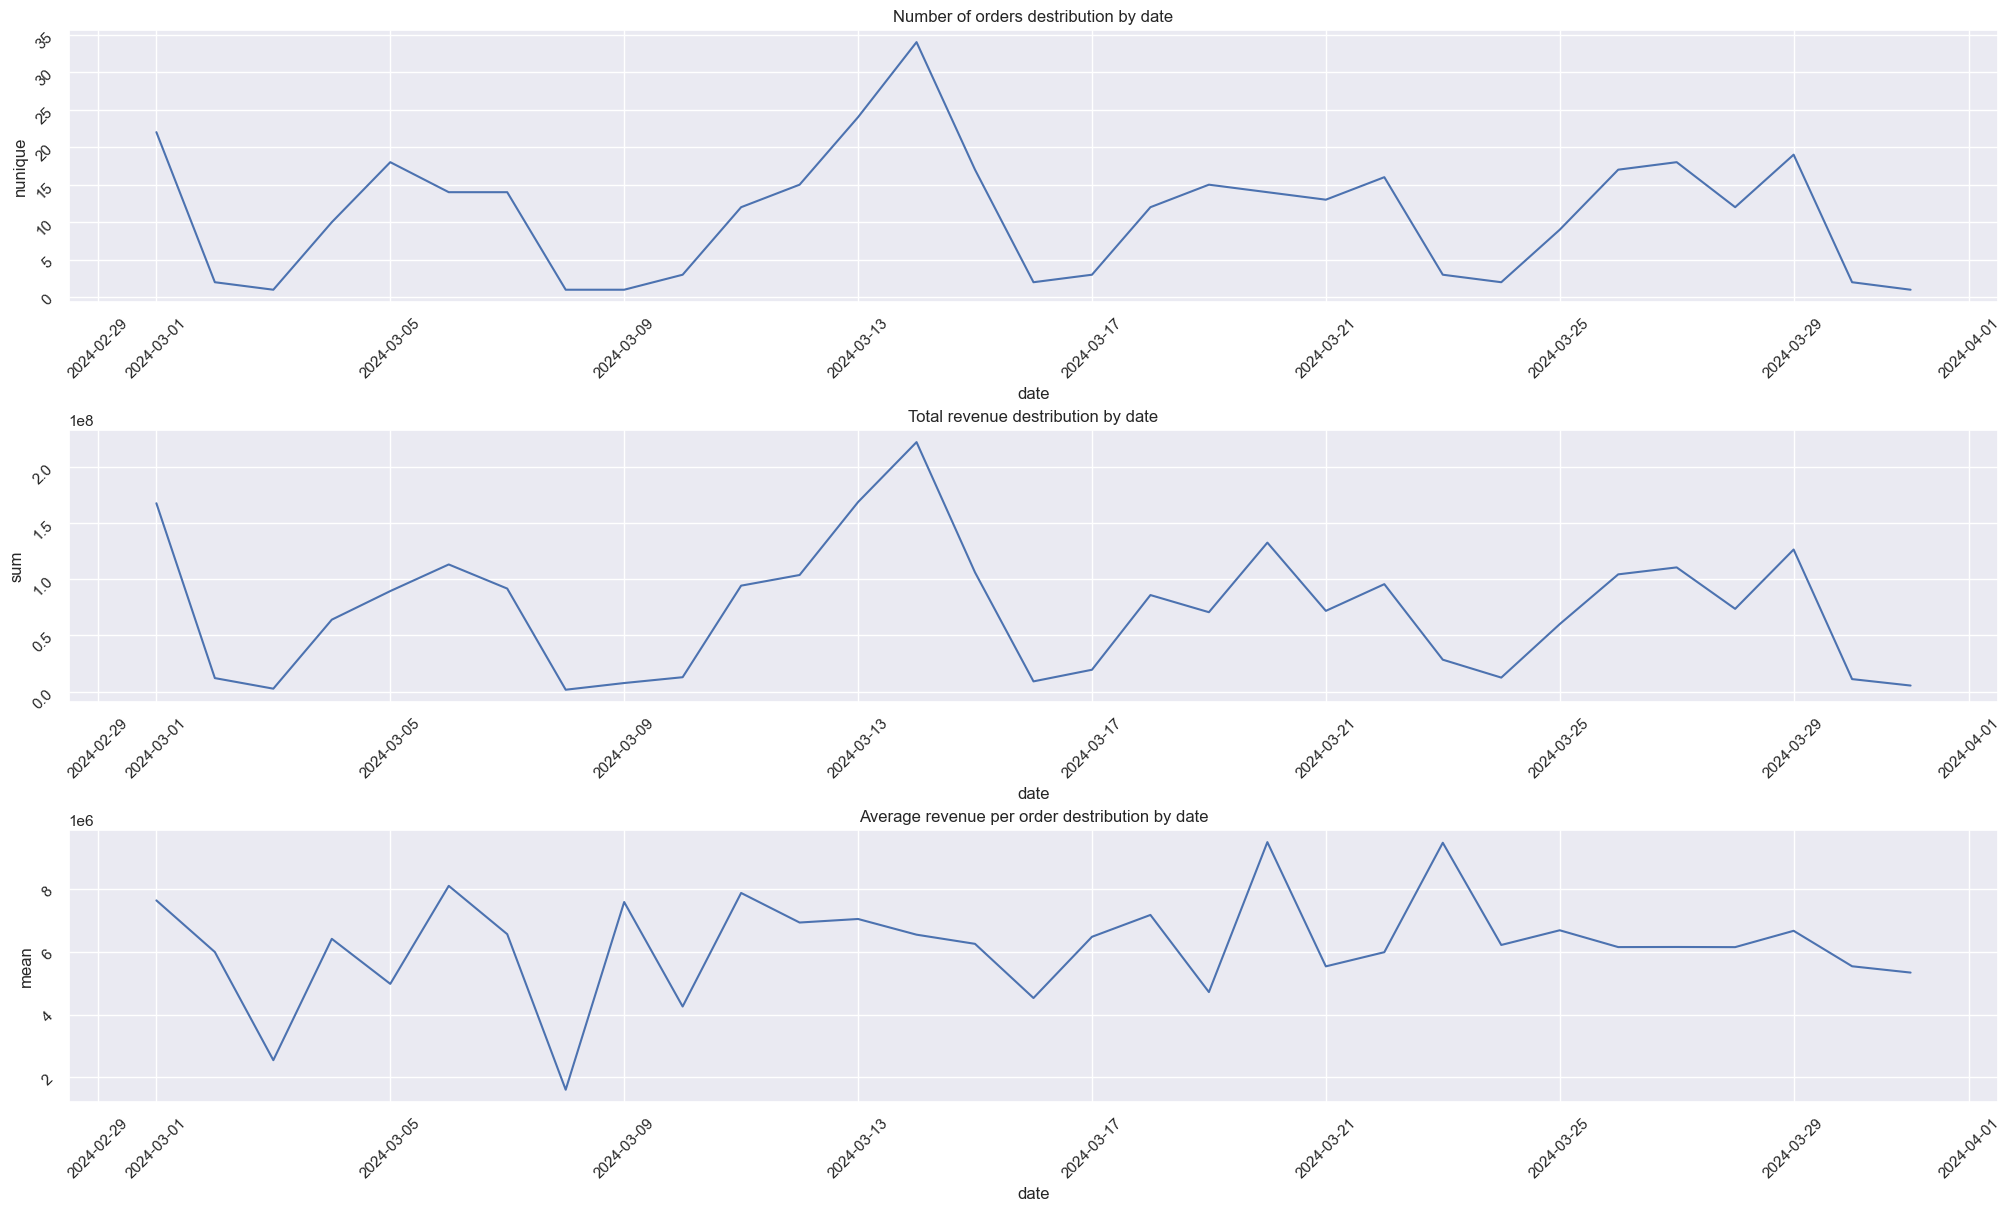

In [890]:
sns.set_theme()
fig, ax = plt.subplots(3,1,figsize = (20,12), constrained_layout = True)
sns.lineplot(data = metrics_by_date, x = 'date', y = 'nunique', ax = ax[0])
ax[0].set_title("Number of orders destribution by date")
ax[0].tick_params(labelrotation=45)
sns.lineplot(data = metrics_by_date, x = 'date', y = 'sum', ax = ax[1])
ax[1].set_title("Total revenue destribution by date")
ax[1].tick_params(labelrotation=45)
sns.lineplot(data = metrics_by_date, x = 'date', y = 'mean', ax = ax[2])
ax[2].set_title("Average revenue per order destribution by date")
ax[2].tick_params(labelrotation=45)
plt.show()

На основе графика можно сделать следущие выводы:
1) число заказов и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день число заказов выросло, то выручка может упасть, и наоборот: число заказов упало — в этот же день выручка выросла)
2) средний чек и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день средний чек вырос, то выручка может упасть, и наоборот: средний чек упал — в этот же день выручка выросла)
3) в день с наибольшим числом заказов выручка максмимальна, а средний чек не показывает максимальное значение

## 14

Далее будем работать с брендами товаров. Для начала создадим колонку брендов, как первая часть, до запятой, в названии товара:

In [891]:
df_full['brand'] = df_full.name.apply(lambda x: x.split(',')[0])



Посчитаю, сколько брендов были в составе заказов (даже отмененных), сколькими брендами интересовались клиенты:

In [892]:
df_full['brand'].value_counts().size

121

## 15

Посчитаю выручку по каждому бренду и сколько подтвержденных заказов товара этого бренда было сделано:

In [893]:
df_brands = df_full\
.query("status =='confirmed'")\
.groupby("brand", as_index = False)\
.agg({'order_id': pd.Series.nunique, 'revenue':'sum'})\
.rename(columns = {'order_id':'total_orders'})\
.sort_values(by = ['total_orders','revenue'], ascending = [False, False])\
.round(1)

In [894]:
df_brands['avg_sales'] = df_brands['revenue'] / df_brands['total_orders']

In [895]:
df_brands

,brand,total_orders,revenue,avg_sales
46,JBL,264,266596053.100,1009833.534
43,Heco,229,238816349.300,1042866.154
120,Yamaha,218,165865087.700,760849.026
53,Klipsch,205,203902418.500,994645.944
62,Magnat,154,114198917.500,741551.412
...,...,...,...,...
66,Microsoft,1,38542.600,38542.600
8,AudioSource,1,33881.700,33881.700
40,Fosi Audio,1,31294.200,31294.200
18,Bravo Audio,1,24050.900,24050.900


Получается, что JBL - бренд с наибольшей выручкой для компании, более того, у него также максимальное количество заказов, при этом средний чек не максимальный.

## 16

Далее определю, какое количество товаров из общего каталога востребовано клиентами компании. Найду количество товаров, которые есть в каталоге, но ни разу не были заказаны:

In [896]:
ordered_products = df_confirmed.product_id.unique()

In [897]:
df_products['is_in_orders'] = df_products.id.apply(lambda x: 'yes' if x in ordered_products else 'no')

In [898]:
df_products.head()

,id,name,price,category,is_in_orders
0,36,"Anthem, AVM 70",2580.030,AV-процессор,no
1,40,"Arcam, AV860",3400.640,AV-процессор,no
2,41,"Arcam, AVR30",3600.850,AV-процессор,no
3,205,"Denon, AVC-X8500H",3600.950,AV-процессор,no
4,206,"Denon, AVC-X6700H",2225.500,AV-процессор,no


In [899]:
df_products.is_in_orders.value_counts()

is_in_orders
yes    1180
no      497
Name: count, dtype: int64

Получается, что 30% товаров (497 позиций) ни разу не были заказаны.

## 17

Далее определю какие бренды имеют долю невостребованных позиций больше половины, то есть позиций, которые ни разу не были заказаны. При этом буду считать, что маленькие бренды, до 15 позиций, не будут учитываться.

In [900]:
df_products['brand'] = df_products.name.apply(lambda x: x.split(",")[0])

In [901]:
df_products.head()

,id,name,price,category,is_in_orders,brand
0,36,"Anthem, AVM 70",2580.030,AV-процессор,no,Anthem
1,40,"Arcam, AV860",3400.640,AV-процессор,no,Arcam
2,41,"Arcam, AVR30",3600.850,AV-процессор,no,Arcam
3,205,"Denon, AVC-X8500H",3600.950,AV-процессор,no,Denon
4,206,"Denon, AVC-X6700H",2225.500,AV-процессор,no,Denon


In [902]:
brands_products = df_products\
.groupby(["brand", "is_in_orders"], as_index = False)\
.agg({"id":"count"})\
.pivot(values = 'id', index = 'brand', columns = 'is_in_orders')\
.fillna(0)\
.reset_index()

In [903]:
brands_products.columns.name = None

In [904]:
brands_products = brands_products.rename(columns = {'no': 'total_no', 'yes': 'total_yes'})

In [905]:
brands_products['total_items'] = brands_products.total_no+brands_products.total_yes

Посчитаю долю невостребованных товаров для каждого бренда:

In [906]:
brands_products["share_no"] = brands_products.total_no/ (brands_products.total_yes+ brands_products.total_no)
brands_products["share_yes"] = brands_products.total_yes/ (brands_products.total_yes+ brands_products.total_no)

In [907]:
brands_products.query("(total_items >= 15) and (share_no > 0.5)")

,brand,total_no,total_yes,total_items,share_no,share_yes
32,Dali,49.000,18.000,67.000,0.731,0.269
60,KEF,54.000,28.000,82.000,0.659,0.341
77,Marantz,19.000,3.000,22.000,0.864,0.136
94,Pioneer,70.000,33.000,103.000,0.680,0.320


Итого получаем, что 4 бренда имеют более 50% невостребованных позиций.

## 18

Расмотрим подробно распределение цен (в долларах) у брендов, у которых более 50% невостребованных позиций:

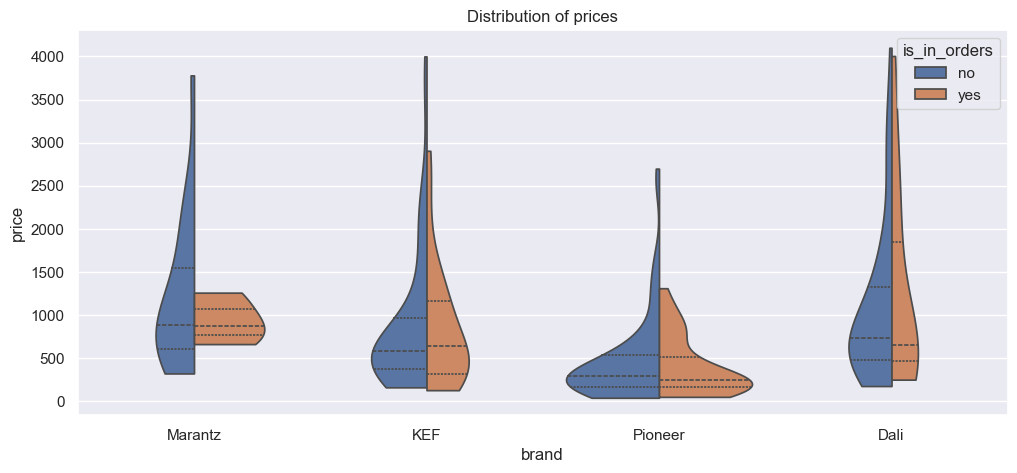

In [908]:
plt.figure(figsize=(12,5))
sns.violinplot(df_products.query("brand in ['Dali','KEF', 'Marantz','Pioneer']"), x = "brand" , y = "price", hue = 'is_in_orders',split = True, inner="quart", cut=0)
plt.title("Distribution of prices")
plt.show()

Рассмотрим каждый бренд:
1) Marantz - покупатели заказывают только товары среднего ценового сегмента. Невостребованные позиции есть во всех ценовых сегментах.
2) KEF - покупатели заказывают дешевые и средние по цене позиции. Невостребованы преимущественно дешевые товары, а также наиболее дорогие.
3) Pioneer - покупатели заказывают преимущественно очень дешевые товары. Однако и болбшинство невостребованных позиции в этом сегменте.
4) Dali - востребованне и невостребованные позиции распределены почти равномерно по цене.

## 19

Посчитаем отношение сanceled/confirmed для всех категорий товаров:

In [909]:
df_full['brand'] = df_full.name.apply(lambda x: x.split(",")[0])

In [910]:
df_cat_share = df_full\
.pivot_table(columns='status', index='category', values='quantity', aggfunc='sum')\
.reset_index()

In [911]:
df_cat_share.columns.name = None

In [912]:
df_cat_share\
.rename(columns={"canceled":"total_canceled", "confirmed":"total_confirmed"}, inplace=True)

In [913]:
df_cat_share['canceled/confirmed'] = df_cat_share.total_canceled/df_cat_share.total_confirmed

In [914]:
df_cat_share = df_cat_share\
.sort_values(by = ['canceled/confirmed','total_confirmed','total_canceled'])\
.reset_index(drop = True)

In [915]:
df_cat_share

,category,total_canceled,total_confirmed,canceled/confirmed
0,AV-ресивер,16,238,0.067
1,AV-процессор,6,89,0.067
2,Домашний кинотеатр,48,670,0.072
3,Виниловый проигрыватель,10,125,0.080
4,Беспроводная акустика,476,5476,0.087
5,Интегральный усилитель,17,187,0.091
6,Саундбар,596,6490,0.092
7,Динамический микрофон,142,1488,0.095
8,Проводные наушники,890,7680,0.116
9,Система караоке,50,422,0.118


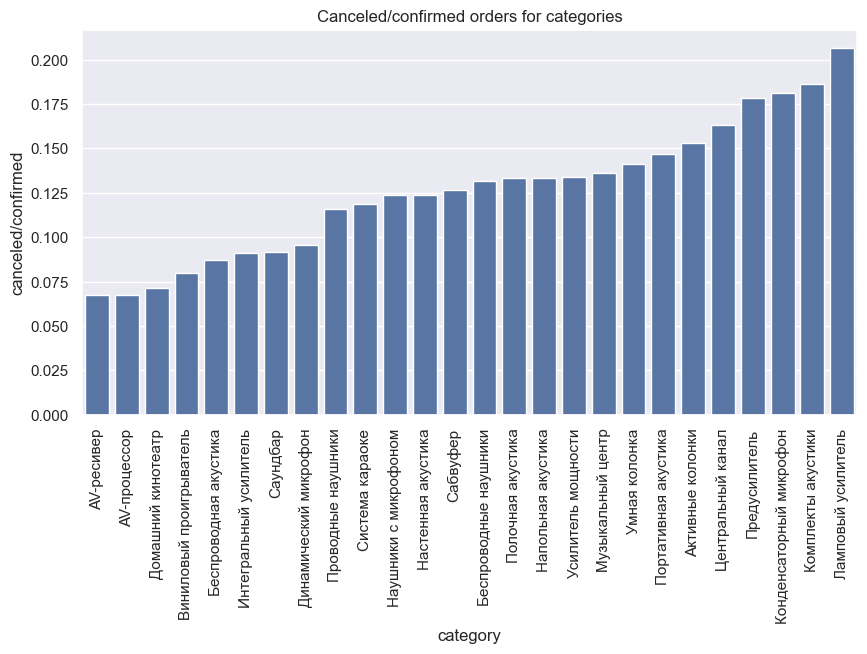

In [916]:
plt.figure(figsize=(10, 5))
sns.barplot(df_cat_share, x = 'category', y = 'canceled/confirmed')
plt.tick_params(axis = 'x',labelrotation = 90)
plt.title("Canceled/confirmed orders for categories")
plt.show()

Итого получаем, что больше заказов отменено в отношении к подтвержденным у Ламповых усилителей, Комплектов акустики, Конденсаторных микрофонов и Предусилителей.

## 20

Расчитаем эту метрику по брендам:

In [917]:
df_brand_share = df_full\
.pivot_table(columns='status', index='brand', values='quantity', aggfunc='sum')\
.reset_index()\
.fillna(0)

In [918]:
df_brand_share.columns.name = None

In [919]:
df_brand_share\
.rename(columns={"canceled":"total_canceled", "confirmed":"total_confirmed"}, inplace=True)

In [920]:
df_brand_share['canceled/confirmed'] = df_brand_share.total_canceled/df_brand_share.total_confirmed

In [921]:
df_brand_share = df_brand_share\
.sort_values(by = ['canceled/confirmed','total_confirmed','total_canceled'])\
.reset_index(drop = True)

In [922]:
df_brand_share

,brand,total_canceled,total_confirmed,canceled/confirmed
0,AudioSource,0.000,3.000,0.000
1,Bravo Audio,0.000,3.000,0.000
2,Bryston,0.000,3.000,0.000
3,Technics,0.000,3.000,0.000
4,Crown,0.000,4.000,0.000
...,...,...,...,...
116,Karaoke USA,5.000,7.000,0.714
117,Bowers & Wilkins,33.000,43.000,0.767
118,Sonance,22.000,22.000,1.000
119,MAONO,20.000,17.000,1.176


Теперь рассмотрим те бренды, у которых нет отмененных заказов, посмотрим на общее количество заказов у таких брендов:

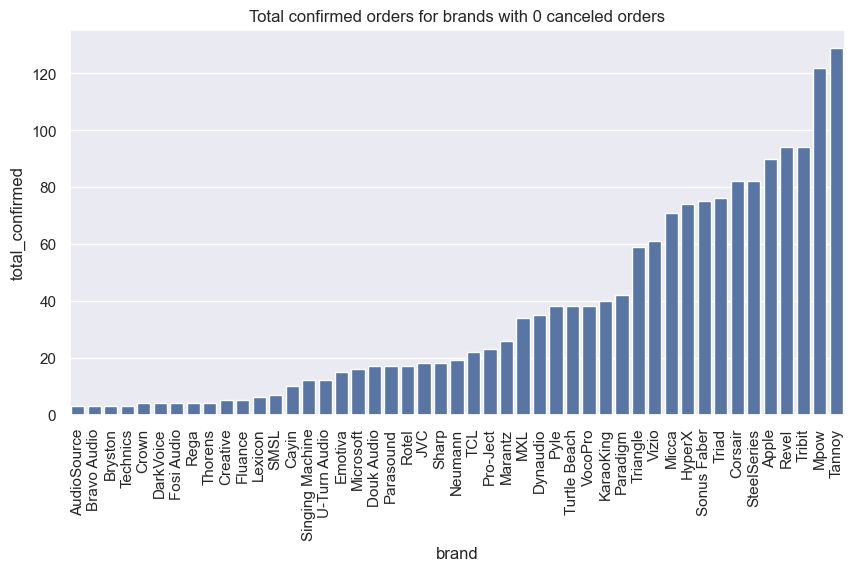

In [923]:
plt.figure(figsize=(10, 5))
sns.barplot(df_brand_share[df_brand_share['canceled/confirmed']==0], x = 'brand', y = 'total_confirmed')
plt.tick_params(axis = 'x',labelrotation = 90)
plt.title("Total confirmed orders for brands with 0 canceled orders")
plt.show()

У большинства брендов с 0 отмен подтверженных заказов тоже очень маленькое количество. Исключение: Mpow, Tannoy (>100 заказов)

Теперь рассмотрим бренды, у которых метрика выше 0.25, т.е. на одну часть отмененных заказов приходится меньше четырех частей подтвержденных заказов:

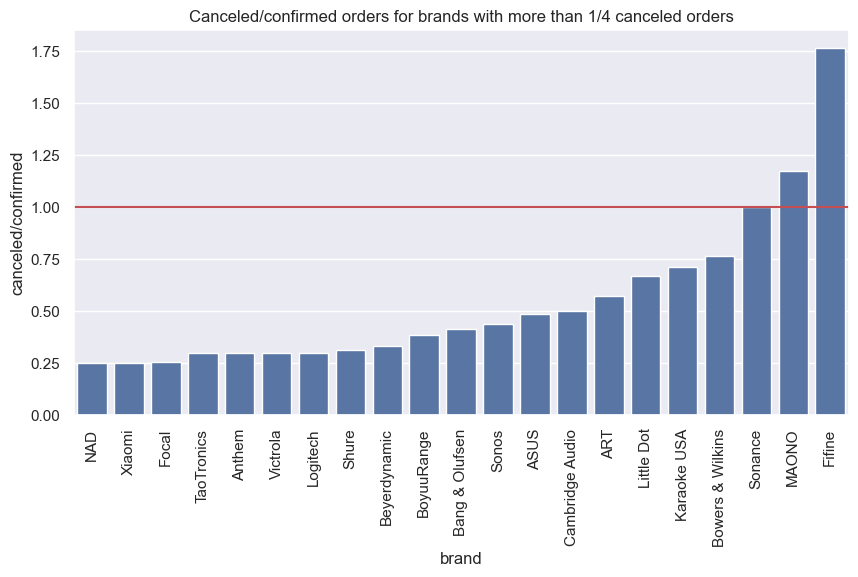

In [924]:
plt.figure(figsize=(10, 5))
sns.barplot(df_brand_share[df_brand_share['canceled/confirmed']>=0.25], x = 'brand', y = 'canceled/confirmed')
plt.tick_params(axis = 'x',labelrotation = 90)
plt.axhline(y = 1, color = 'r', linestyle = '-') 
plt.title("Canceled/confirmed orders for brands with more than 1/4 canceled orders")
plt.show()

В итоге видим, что есть несколько брендов у которых отмененных заказов столько же или больше, чем подтвержденных: Sonnance, MAONO, Fifine.

## 21

Рассмотри самые "ценные" бренды в каждой категории (которые принесли наибольшую выручку и которые наибольшую выручку упустили):

In [925]:
df_categories = df_full\
.groupby(['category', 'brand', 'status'], as_index = False)\
.agg({"revenue":"sum", 'quantity':"sum"})\
.sort_values(by = ['category',"revenue", "quantity",'brand'], ascending=[True, False, False, True])\
.reset_index(drop = True)

In [926]:
df_categories = df_categories\
.groupby(['category', 'status'])\
.head(1)\
.reset_index(drop=True)\
.sort_values(by = ['category','revenue'])

In [927]:
df_categories = df_categories\
.merge(df_categories\
       .groupby("category")\
       .agg({'revenue':"sum"})\
       .rename(columns={"revenue":"sort"}), on = 'category')

In [928]:
df_categories = df_categories\
.groupby(['sort', 'category'], as_index = False)\
.apply(lambda x: x.sort_values('revenue', ascending=True))\
.sort_values(by = 'sort', ascending=False)\
.drop(columns=['sort'])\
.reset_index(drop=True)

C:\Users\egona\AppData\Local\Temp\ipykernel_20804\3975178940.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('revenue', ascending=True))\


In [929]:
df_categories.loc[df_categories['status']=='canceled','revenue'] *= -1

In [930]:
df_categories = df_categories\
.sort_values(by = ['status', 'revenue', 'quantity'], ascending=[False, False,False])\
.reset_index(drop=True)

In [931]:
df_categories['revenue'] = abs(df_categories['revenue']) 

In [932]:
df_categories

,category,brand,status,revenue,quantity
0,Напольная акустика,Heco,confirmed,67956182.301,637
1,Беспроводная акустика,KEF,confirmed,65530545.019,512
2,Саундбар,Klipsch,confirmed,45359287.460,880
3,Полочная акустика,JBL,confirmed,42487646.148,699
4,Сабвуфер,Heco,confirmed,31754177.042,759
5,Активные колонки,KEF,confirmed,31072970.508,182
6,Беспроводные наушники,Yamaha,confirmed,23430958.150,1258
7,Настенная акустика,Klipsch,confirmed,18717822.088,629
8,Умная колонка,Harman Kardon,confirmed,16230498.097,624
9,Портативная акустика,KEF,confirmed,13895026.400,322


В итоге получаем таблицу, где наглядно можно увидеть самые прибыльные и убыточные бренды в каждой категории.

## 22

Теперь определим сколько прибыли принесла и потеряла каждая категория товара суммарно:

In [933]:
df_revenue_status = df_full\
.groupby(['category', 'status'], as_index = False)\
.agg({"revenue":"sum"})

In [934]:
df_canceled_revenue = df_revenue_status.query("status == 'canceled'")
df_confirmed_revenue = df_revenue_status.query("status == 'confirmed'")\
.sort_values(by = ['revenue','category'], ascending=[False, False])\
.reset_index(drop = True)

In [935]:
df_canceled_revenue = df_canceled_revenue.set_index('category')
df_canceled_revenue = df_canceled_revenue.reindex(index=df_confirmed_revenue['category'])
df_canceled_revenue = df_canceled_revenue.reset_index()

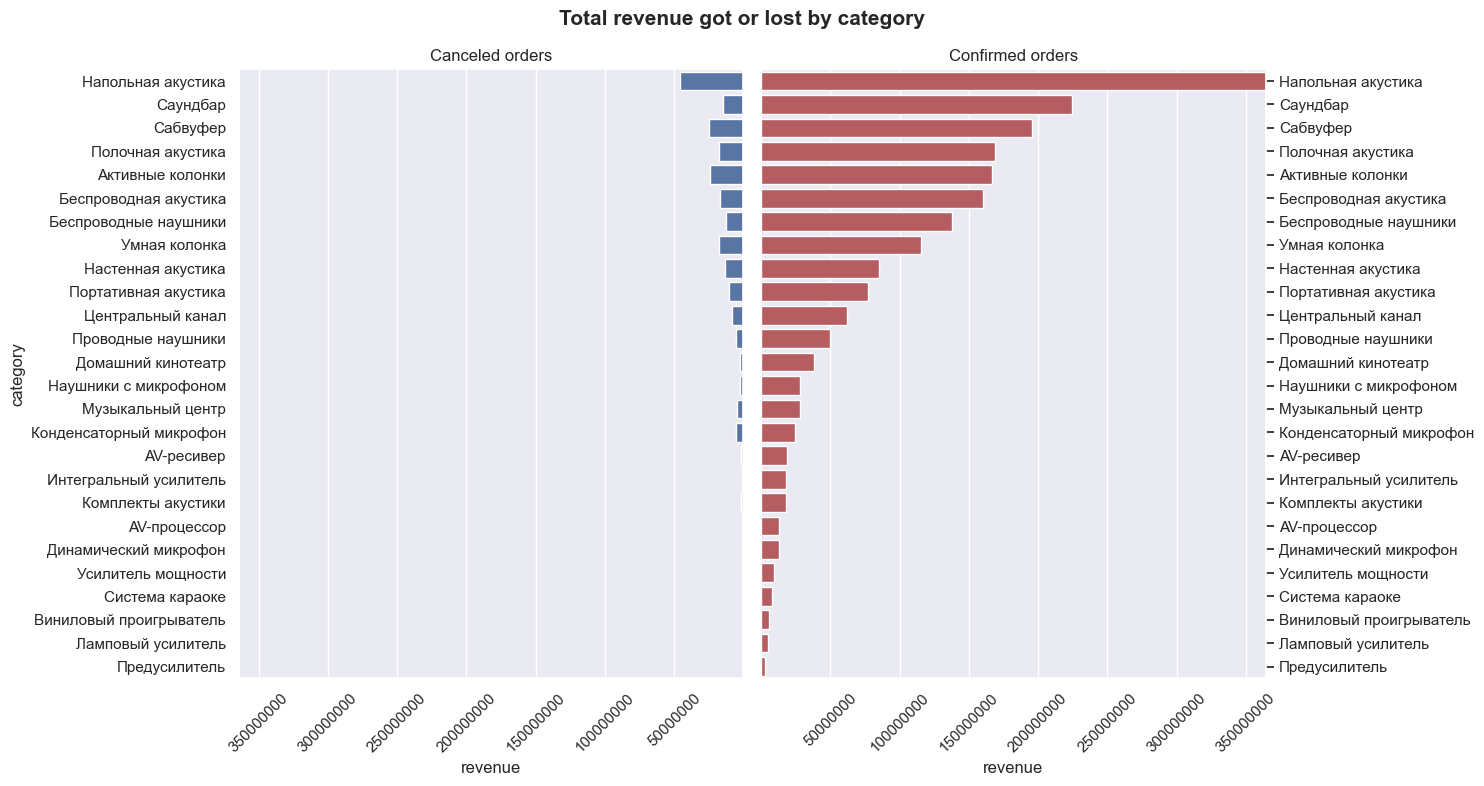

In [936]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle('Total revenue got or lost by category', fontsize=15, fontweight='bold')
sns.barplot(df_canceled_revenue,y = 'category', x = 'revenue', ax = ax[0], orient='h')
sns.barplot(df_confirmed_revenue,y = 'category', x = 'revenue', ax = ax[1], orient='h', color = 'r')
ax[0].set_title("Canceled orders")
ax[1].set_title("Confirmed orders")
min_rev = df_revenue_status.revenue.min()
max_rev = df_revenue_status.revenue.max()
for i in ax:
    i.get_xaxis().get_major_formatter().set_scientific(False)
    i.tick_params(axis = 'x', labelrotation=45)
    i.set_xlim(min_rev, max_rev)
ax[0].invert_xaxis()
ax[1].yaxis.tick_right()
ax[1].set_ylabel(None)
plt.tight_layout()
plt.show()

Итого получаем, что Напольная акустика принесла наибольшую прибыль, при этом она также была самой отменяемой по общей стоимости отмененных заказов.

# Отчет по продажам менеджеров

## 23

Проведем исследование эффективности менеджеров по продажам. 
Для начала найдем сколько заказов оформил (из подтвержденных) каждый менеджер, какую выручку принес компании. Далее посчитаем долю подтвержденных заказов каждого менеджера от общего количества, аналогично с выручкой.

In [937]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [938]:
managers_performance = df_confirmed\
.groupby("manager", as_index = False)\
.agg({"order_id":pd.Series.nunique, 'revenue':"sum"})\
.rename(columns = {"order_id":'total_orders'})\
.sort_values(by = ["revenue", 'total_orders'])\
.reset_index(drop = True)



In [939]:
managers_performance['total_orders_share'] = managers_performance.total_orders/managers_performance.total_orders.sum()
managers_performance['total_revenue_share'] = managers_performance.revenue/managers_performance.revenue.sum()

In [940]:
managers_performance

,manager,total_orders,revenue,total_orders_share,total_revenue_share
0,Сергей Контрабасов,5,28572232.634,0.016,0.014
1,Аркадий Октавин,5,29736777.026,0.016,0.015
2,Антон Скрипкин,7,51502684.749,0.023,0.025
3,Анастасия Дудкина,20,123450361.324,0.065,0.061
4,Надежда Гармошкина,21,134783644.493,0.068,0.066
5,Екатерина Тарелкина,28,178157639.093,0.091,0.087
6,Ксения Балалайкина,27,181762137.427,0.087,0.089
7,Алексей Саксофонов,27,195343533.804,0.087,0.096
8,Владимир Ударников,31,208486484.333,0.100,0.102
9,Максим Барабанов,40,240147807.034,0.129,0.118


На основе таблицы построю столбчатые диаграммы, чтобы наглядно определить результативность каждого менеджера.

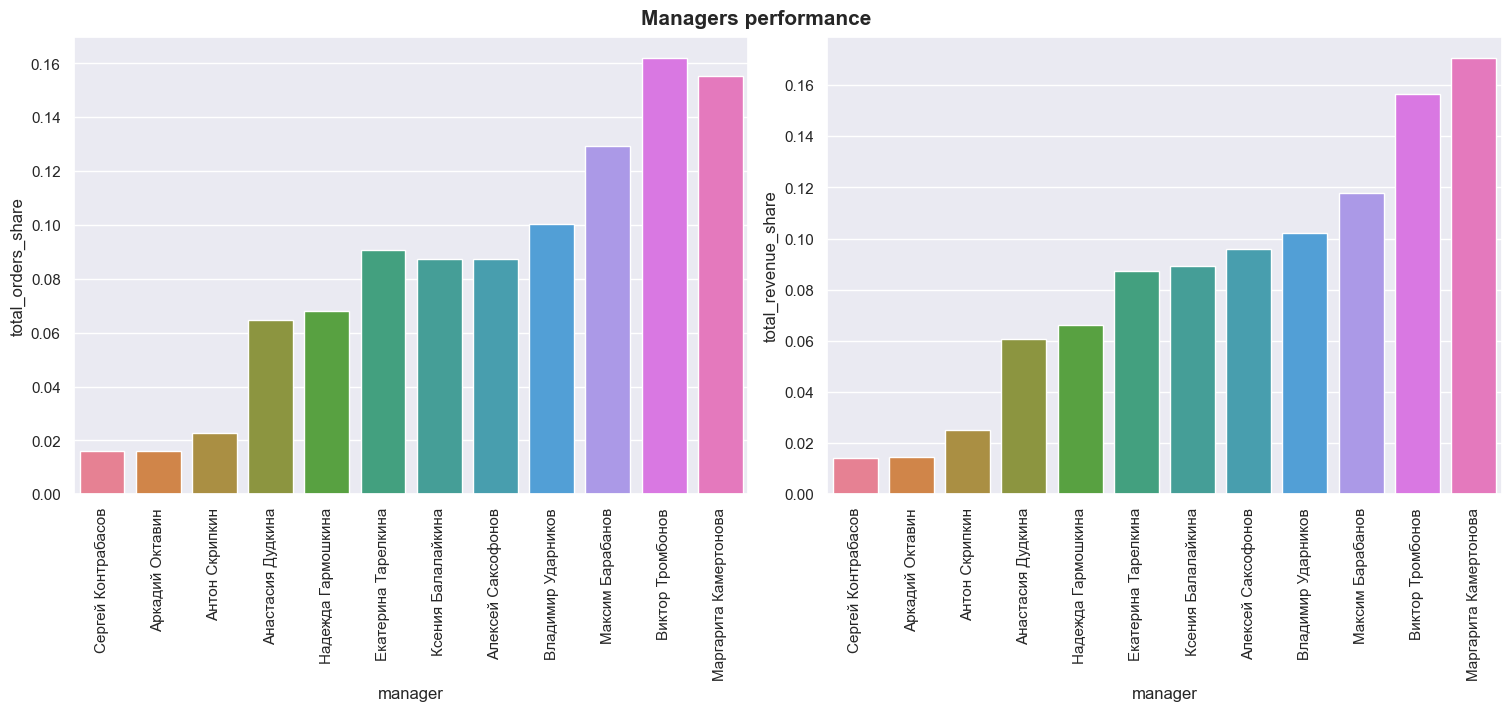

In [941]:
fig, ax = plt.subplots(1,2,figsize = (15,7), constrained_layout = True)
sns.barplot(data = managers_performance, x = 'manager', y = 'total_orders_share', ax = ax[0], hue='manager')
sns.barplot(data = managers_performance, x = 'manager', y = 'total_revenue_share', ax = ax[1], hue='manager')
ax[0].tick_params(axis = 'x', labelrotation=90)
ax[1].tick_params(axis = 'x', labelrotation=90)
fig.suptitle("Managers performance", fontsize=15, fontweight='bold')
plt.show()

Основываясь на таблце и графике могу сделать выводы:
1) Маргарита Камертонова - лучший менеджер по доле выручки.
2) Виктор Тромбонов - лучший менеджер по доле заказов.
3) Доли выручки и заказов у большинства менеджеров пропорциональны.
4) По графику возможно определить явно отстающих (причем по обоим показателям) менеджеров: Контрабасов, Октавин, Скрипкин.

## 24

Расмотрю производительность менеджеров с точки зрения подтвержденных и отмененных заказов:

In [942]:
managers_produced_orders = df_full\
.groupby(["manager",'status'], as_index = False)\
.agg({"order_id":pd.Series.nunique, 'revenue':'sum'})\
.rename(columns = {"order_id":'total_orders', 'revenue': 'total_revenue'})\
.pivot_table(index = 'manager', columns='status', values=['total_orders', 'total_revenue'])\
.fillna(0)


In [943]:
managers_produced_orders = managers_produced_orders.droplevel(0, axis=1).rename_axis(None, axis=1)

In [944]:
managers_produced_orders.columns = ['orders_canceled', 'orders_confirmed', 'revenue_canceled', 'revenue_confirmed']

In [945]:
managers_produced_orders.reset_index(level=0, inplace=True)

Введу несколько метрик, часть из которых будут рассчитываться относительно других показателей менеджера, а остальные относительно суммарных показателей всех менеджеров:

In [946]:
managers_produced_orders['orders_confirmed_share_from_total'] = managers_produced_orders['orders_confirmed']/managers_produced_orders['orders_confirmed'].sum()
managers_produced_orders['revenue_confirmed_share_from_total'] = managers_produced_orders['revenue_confirmed']/managers_produced_orders['revenue_confirmed'].sum()
managers_produced_orders['orders_canceled_share_from_total'] = managers_produced_orders['orders_canceled']/managers_produced_orders['orders_canceled'].sum()
managers_produced_orders['revenue_canceled_share_from_total'] = managers_produced_orders['revenue_canceled']/managers_produced_orders['revenue_canceled'].sum()
managers_produced_orders['orders_confirmed_share_by_manager'] = managers_produced_orders['orders_confirmed']/ (managers_produced_orders['orders_confirmed']+managers_produced_orders['orders_canceled'])
managers_produced_orders['revenue_confirmed_share_by_manager'] = managers_produced_orders['revenue_confirmed']/ (managers_produced_orders['revenue_confirmed']+managers_produced_orders['revenue_canceled'])

In [947]:
managers_produced_orders

,manager,orders_canceled,orders_confirmed,revenue_canceled,revenue_confirmed,orders_confirmed_share_from_total,revenue_confirmed_share_from_total,orders_canceled_share_from_total,revenue_canceled_share_from_total,orders_confirmed_share_by_manager,revenue_confirmed_share_by_manager
0,Алексей Саксофонов,3.000,27.000,24291566.391,195343533.804,0.087,0.096,0.081,0.102,0.900,0.889
1,Анастасия Дудкина,1.000,20.000,7632796.440,123450361.324,0.065,0.061,0.027,0.032,0.952,0.942
2,Антон Скрипкин,1.000,7.000,8778355.240,51502684.749,0.023,0.025,0.027,0.037,0.875,0.854
3,Аркадий Октавин,0.000,5.000,0.000,29736777.026,0.016,0.015,0.000,0.000,1.000,1.000
4,Виктор Тромбонов,5.000,50.000,30301306.320,318899926.540,0.162,0.156,0.135,0.127,0.909,0.913
5,Владимир Ударников,5.000,31.000,29828591.433,208486484.333,0.100,0.102,0.135,0.125,0.861,0.875
6,Екатерина Тарелкина,4.000,28.000,19695067.114,178157639.093,0.091,0.087,0.108,0.083,0.875,0.900
7,Ксения Балалайкина,5.000,27.000,30308321.062,181762137.427,0.087,0.089,0.135,0.127,0.844,0.857
8,Максим Барабанов,3.000,40.000,17743808.026,240147807.034,0.129,0.118,0.081,0.075,0.930,0.931
9,Маргарита Камертонова,7.000,48.000,49692973.646,347388593.109,0.155,0.170,0.189,0.209,0.873,0.875


In [948]:
managers_produced_orders = managers_produced_orders\
.sort_values(by = ['revenue_confirmed_share_from_total', "orders_confirmed_share_from_total"])

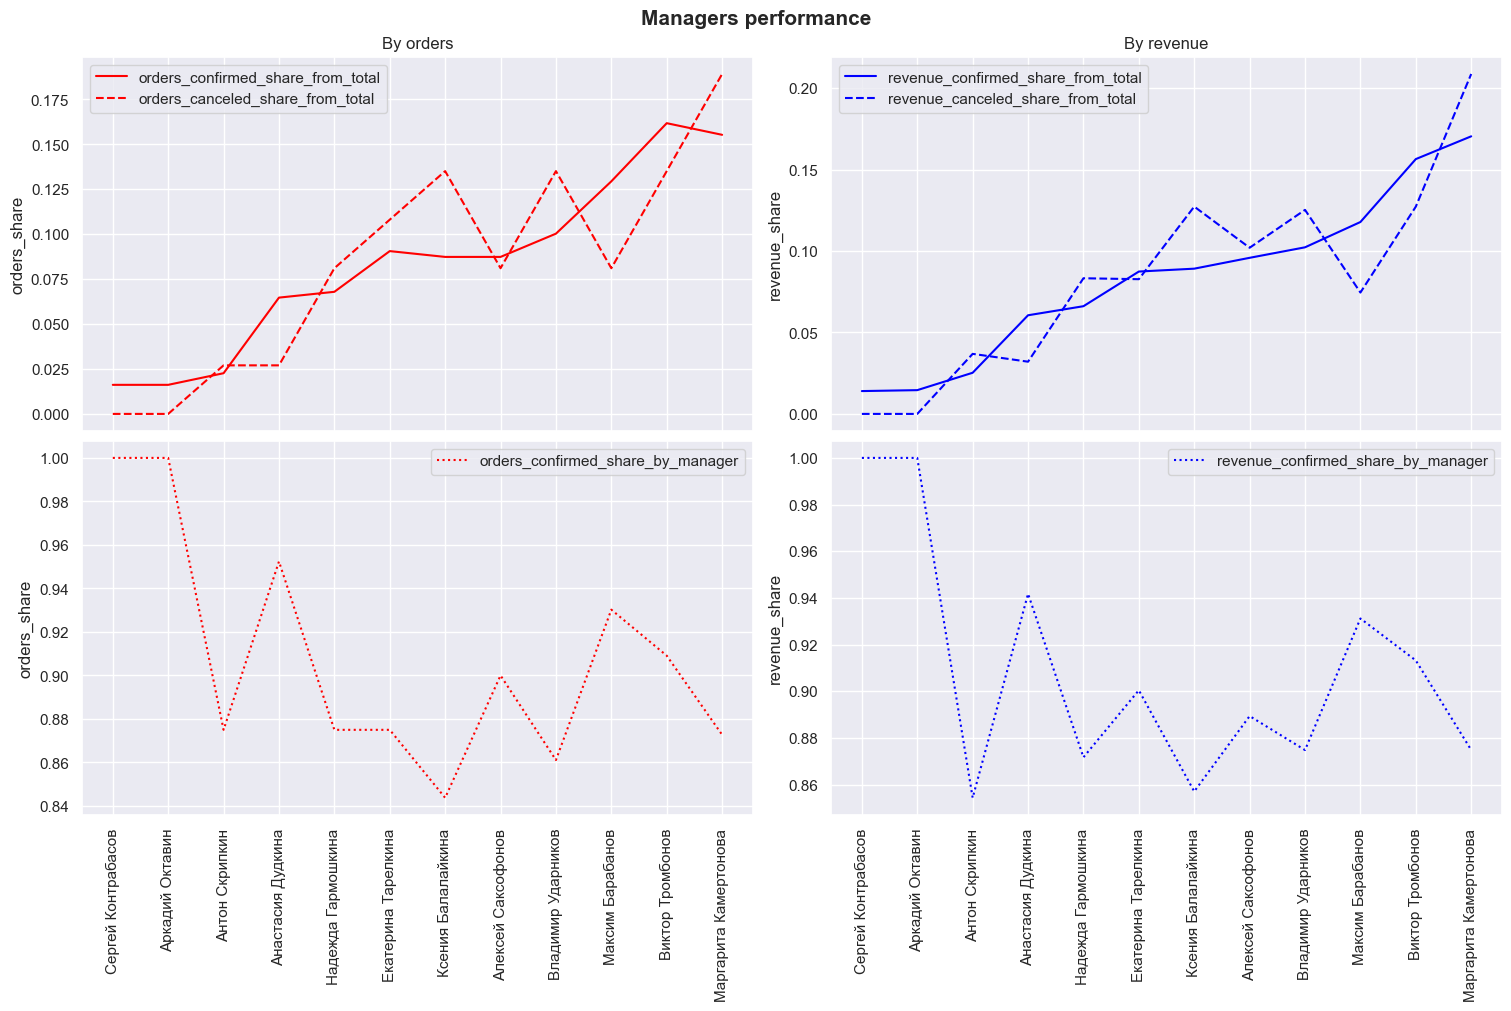

In [949]:
fig, ax = plt.subplots(2,2,figsize = (15,10), constrained_layout = True)
sns.lineplot(data = managers_produced_orders, x = 'manager', y = 'orders_confirmed_share_from_total', label = 'orders_confirmed_share_from_total', color = 'red', ax = ax[0,0])
sns.lineplot(data = managers_produced_orders, x = 'manager', y = 'orders_canceled_share_from_total', label = 'orders_canceled_share_from_total', color = 'red', linestyle='dashed', ax = ax[0,0])

sns.lineplot(data = managers_produced_orders, x = 'manager', y = 'revenue_confirmed_share_from_total', label = 'revenue_confirmed_share_from_total', color = 'blue', ax = ax[0,1])
sns.lineplot(data = managers_produced_orders, x = 'manager', y = 'revenue_canceled_share_from_total', label = 'revenue_canceled_share_from_total', color = 'blue', linestyle='dashed', ax = ax[0,1])

sns.lineplot(data = managers_produced_orders, x = 'manager', y = 'orders_confirmed_share_by_manager', label = 'orders_confirmed_share_by_manager', color = 'red', linestyle='dotted', ax = ax[1,0])
sns.lineplot(data = managers_produced_orders, x = 'manager', y = 'revenue_confirmed_share_by_manager', label = 'revenue_confirmed_share_by_manager', color = 'blue', linestyle='dotted', ax = ax[1,1])

fig.suptitle("Managers performance", fontsize=15, fontweight='bold')
for row in ax:
    for axis in row:
        axis.tick_params(axis='x', labelrotation=90)
        axis.set_xlabel(None)
ax[0,0].set_ylabel("orders_share")
ax[0,1].set_ylabel("revenue_share")
ax[1,0].set_ylabel("orders_share")
ax[1,1].set_ylabel("revenue_share")
ax[0,0].set(xticklabels=[])
ax[0,1].set(xticklabels=[])
ax[0,0].title.set_text('By orders')
ax[0,1].title.set_text('By revenue')
plt.show()

График показывает, что большое количество заказов, которые обслуживает М. Камертонова в итоге отменяются, ни смотря на наибольшую долю выручки от суммарной среди менеджеров у нее. Хотя она все еще лучшая по доле выручки от суммарной из подтвержденных заказов.

Лучшим менеджером по количеству подтвержденных заказов от суммарного остается В. Трамбонов.

При это лучшим по компиляции долей от суммарной по выручке, количеству заказов и по долям для каждого менеджера (то есть доля подтвержденной выручки/кол-во заказов от общей выручки/кол-ва заказов, которую принес конкретный менеджер) является М. Барабанов. 

## Итоги

В рамках анализа данных об оптовых продажах аудиотехники были выполнены следующие задачи:

1) Проведены сбор, очистка и объединение данных для их дальнейшего анализа.
2) Определены дни месяца с наибольшим количество заказов.
3) Определено распределение заказов по дням недели, построен соответствующий график.
4) Определено среднее количество заказов по дням недели, построен соответствующий график.
5) Определены дни, которые выбиваются из "сезонности" по количеству заказов, построен соответствующий график.
6) Определено отношение отмененных заказов к подтвержденным по датам, построен соответствующий график.
7) Определена причина аномалии в данных.
8) Расчитаны выручки в рублях по каждому заказу.
9) Расчитаны средний чек и количество заказов по дням, построен соответствующий график.
10) Расчитаны выручки и количество заказов по каждому бренду.
11) Определено количество невостребованных товаров у каждого бренда.
12) Исследованы распределения цены востребованных и невостребованных товаров у брендов, у которых невостребованных товаров больше половины, построен соответствующий график.
13) Расчитаны соотношения количества отмененых заказов к подтвержденным по брендам и категориям товаров, построены соответствующие графики.
14) Определены наиболее прибыльные бренды в каждой категории товаров; определены бренды в каждой категории, которые чаще всего отменялись.
15) Определена полученная и упущенная выручка по каждой категории, построены соответствующие графики.
16) Определены наиболее эффективные менеджеры по доле выручки и количеству заказов в подтвержденных заказах, построены соответствующие графики.
17) Расмотрена производительность менеджеров с точки зрения подтвержденных и отмененных заказов, расчитаны доли от суммарной выручки и количества заказов, доли для каждого менеджера (то есть доля подтвержденной выручки/кол-во заказов от общей выручки/кол-ва заказов, которую принес конкретный менеджер), построены соответствующие графики.

Таким образом, анализ позволил глубже понять динамику продаж и выявить области для оптимизации товарной линейки, работы менеджеров.